In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib

In [4]:
import os
import shutil
import random

# Define paths
dataset_path = r'C:\Users\user\Desktop\P\static\uploads' # Folder where original dataset is stored
train_path = "dataset/train"
validation_path = "dataset/validation"

# Define split ratio
split_ratio = 0.8  # 80% training, 20% validation
# Create train and validation directories
for folder in ["Healthy", "Early_blight", "Late_blight"]:
    os.makedirs(os.path.join(train_path, folder), exist_ok=True)
    os.makedirs(os.path.join(validation_path, folder), exist_ok=True)

    # Get list of images
    images = os.listdir(os.path.join(dataset_path, folder))
    random.shuffle(images)

    # Split images into train and validation sets
    train_size = int(len(images) * split_ratio)
    train_images = images[:train_size]
    val_images = images[train_size:]

    # Move images to respective directories
    for img in train_images:
        shutil.move(os.path.join(dataset_path, folder, img), os.path.join(train_path, folder, img))
    
    for img in val_images:
        shutil.move(os.path.join(dataset_path, folder, img), os.path.join(validation_path, folder, img))

print("Dataset successfully split into training and validation sets!")


Dataset successfully split into training and validation sets!


In [5]:
# Define directories
train_dir = r'C:\Users\user\Desktop\P\dataset\train'
validation_dir = r'C:\Users\user\Desktop\P\dataset\validation'

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 6505 images belonging to 3 classes.
Found 1627 images belonging to 3 classes.


In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/3
203/203 [==============================] - 721s 3s/step - loss: 1.0164 - accuracy: 0.4936 - val_loss: 0.8270 - val_accuracy: 0.6281
Epoch 2/3
203/203 [==============================] - 678s 3s/step - loss: 0.6691 - accuracy: 0.7162 - val_loss: 0.5964 - val_accuracy: 0.7462
Epoch 3/3
203/203 [==============================] - 681s 3s/step - loss: 0.5380 - accuracy: 0.7828 - val_loss: 0.5628 - val_accuracy: 0.7862


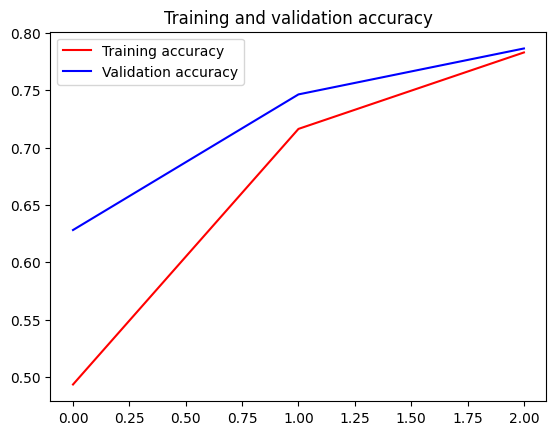

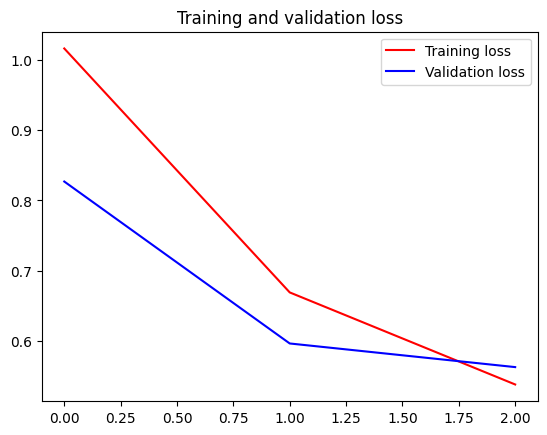

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
target_names = ['Healthy', 'Early Blight', 'Late Blight']
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


51/51 [==============================] - 45s 858ms/step
Confusion Matrix
[[ 45 209 146]
 [ 83 330 232]
 [ 82 298 202]]
Classification Report
              precision    recall  f1-score   support

     Healthy       0.21      0.11      0.15       400
Early Blight       0.39      0.51      0.45       645
 Late Blight       0.35      0.35      0.35       582

    accuracy                           0.35      1627
   macro avg       0.32      0.32      0.31      1627
weighted avg       0.33      0.35      0.34      1627



In [14]:
import gzip
import pickle
import os

joblib.dump(model, "model/model.pkl")
print("CNN model saved as model.pkl")

# Ensure the 'model' directory exists
os.makedirs("model", exist_ok=True)

# Load the model
with open("model/model.pkl", "rb") as f:
    model = pickle.load(f)

# Compress and save inside 'model' folder
compressed_path = "model/model.pkl.gz"
with gzip.open(compressed_path, "wb") as f:
    pickle.dump(model, f)

print(f"Model compressed successfully: {compressed_path}")


CNN model saved as model.pkl
Model compressed successfully: model/model.pkl.gz
